In [1]:
import sys
sys.path.append('../../../')

In [2]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error

Using backend: pytorch


In [3]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [4]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'test_mcc'
metric_filter_2 = 'val_mcc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [5]:
sets_lengths = (0.5, 0.25, 0.25)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = dataset.num_classes

## Baseline

In [6]:
dict_small_acc_train = {}
dict_small_acc_val = {}
dict_small_acc_test = {}
dict_small_rmse_train = {}
dict_small_rmse_val = {}
dict_small_rmse_test = {}
dict_small_mcc_train = {}
dict_small_mcc_val = {}
dict_small_mcc_test = {}

In [7]:
# x_train,x_test,y_train,y_test = train_test_split(dataset.node_features[0].to_numpy(), dataset.targets[0], test_size=0.25, random_state=seed)
g_data = dataset.graphs[0].ndata
feats = g_data['feat']
labels = g_data['label']
train_mask = g_data['train_mask']
val_mask = g_data['val_mask']
test_mask = g_data['test_mask']

# train + val for training, test for test
x_train,x_test = feats[torch.logical_not(test_mask)], feats[test_mask]
y_train,y_test = labels[torch.logical_not(test_mask)], labels[test_mask]

In [8]:
x_train.shape

torch.Size([1125, 4])

In [9]:
x_test.shape

torch.Size([375, 4])

### Logistic Regression

In [10]:
model_lr = LogisticRegression(multi_class='multinomial',random_state=seed, max_iter=800).fit(x_train, y_train)
print(classification_report(y_true=y_test, y_pred=model_lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.76      0.60      0.67        98
           1       0.21      0.05      0.08        95
           2       0.34      0.53      0.41        93
           3       0.55      0.79      0.65        89

    accuracy                           0.49       375
   macro avg       0.46      0.49      0.45       375
weighted avg       0.46      0.49      0.45       375



In [11]:
dict_small_acc_train['logistic_regression'] = model_lr.score(x_train, y_train)
dict_small_acc_test['logistic_regression'] = model_lr.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['logistic_regression']}")
print(f"Test accuracy: {dict_small_acc_test['logistic_regression']}")

dict_small_rmse_train['logistic_regression'] = mean_squared_error(y_true=y_train,y_pred=model_lr.predict(x_train), squared=False)
dict_small_rmse_test['logistic_regression'] = mean_squared_error(y_true=y_test,y_pred=model_lr.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['logistic_regression']}")
print(f"Test rmse: {dict_small_rmse_test['logistic_regression']}")

dict_small_mcc_train['logistic_regression'] = matthews_corrcoef(y_true=y_train,y_pred=model_lr.predict(x_train))
dict_small_mcc_test['logistic_regression'] = matthews_corrcoef(y_true=y_test,y_pred=model_lr.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['logistic_regression']}")
print(f"Test mcc: {dict_small_mcc_test['logistic_regression']}")

Train accuracy: 0.496
Test accuracy: 0.488
Train rmse: 0.9688481133111974
Test rmse: 0.9605553948974868
Train mcc: 0.34443142561242607
Test mcc: 0.33524435059932634


### Random Forest

In [12]:
# x_train_rf,x_val_rf,y_train_rf,y_val_rf = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)
x_train_rf,x_val_rf,x_test_rf = feats[train_mask], feats[val_mask], feats[test_mask]
y_train_rf,y_val_rf,y_test_rf = labels[train_mask], labels[val_mask], labels[test_mask]

In [13]:
n = 20
num_nodes = x_train_rf.shape[0]
model_rf = None
val_acc = 0.0
for k in trange(1,num_nodes, (num_nodes - 1) // n):
    tmp = RandomForestClassifier(random_state=seed, n_estimators=k).fit(x_train_rf,y_train_rf)
    tmp_acc = tmp.score(x_val_rf, y_val_rf)
    if val_acc < tmp_acc:
        val_acc = tmp_acc
        model_rf = tmp

print(classification_report(y_true=y_test, y_pred=model_rf.predict(x_test)))

100%|██████████| 21/21 [00:17<00:00,  1.20it/s]

              precision    recall  f1-score   support

           0       0.70      0.67      0.69        98
           1       0.35      0.31      0.33        95
           2       0.30      0.31      0.30        93
           3       0.58      0.65      0.61        89

    accuracy                           0.49       375
   macro avg       0.48      0.49      0.48       375
weighted avg       0.48      0.49      0.48       375



In [14]:
model_rf

RandomForestClassifier(n_estimators=223, random_state=4444)

In [15]:
dict_small_acc_train['random_forest'] = model_rf.score(x_train_rf, y_train_rf)
dict_small_acc_val['random_forest'] = model_rf.score(x_val_rf, y_val_rf)
dict_small_acc_test['random_forest'] = model_rf.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['random_forest']}")
print(f"Val accuracy: {dict_small_acc_val['random_forest']}")
print(f"Test accuracy: {dict_small_acc_test['random_forest']}")

dict_small_rmse_train['random_forest'] = mean_squared_error(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf), squared=False)
dict_small_rmse_val['random_forest'] = mean_squared_error(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf), squared=False)
dict_small_rmse_test['random_forest'] = mean_squared_error(y_true=y_test,y_pred=model_rf.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['random_forest']}")
print(f"Val rmse: {dict_small_rmse_val['random_forest']}")
print(f"Test rmse: {dict_small_rmse_test['random_forest']}")

dict_small_mcc_train['random_forest'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf))
dict_small_mcc_val['random_forest'] = matthews_corrcoef(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf))
dict_small_mcc_test['random_forest'] = matthews_corrcoef(y_true=y_test,y_pred=model_rf.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['random_forest']}")
print(f"Val mcc: {dict_small_mcc_val['random_forest']}")
print(f"Test mcc: {dict_small_mcc_test['random_forest']}")

Train accuracy: 1.0
Val accuracy: 0.4826666666666667
Test accuracy: 0.48533333333333334
Train rmse: 0.0
Val rmse: 1.019803902718557
Test rmse: 0.9757048734120374
Train mcc: 1.0
Val mcc: 0.3104678564683043
Test mcc: 0.31452820594268094


### KNN Classifier

In [16]:
model_knn = KNeighborsClassifier(n_neighbors=out_feats).fit(x_train,y_train)
print(classification_report(y_true=y_test, y_pred=model_knn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.62      0.67      0.65        98
           1       0.25      0.27      0.26        95
           2       0.26      0.27      0.26        93
           3       0.45      0.34      0.38        89

    accuracy                           0.39       375
   macro avg       0.39      0.39      0.39       375
weighted avg       0.40      0.39      0.39       375



In [17]:
dict_small_acc_train['knn_classifier'] = model_knn.score(x_train_rf, y_train_rf)
dict_small_acc_test['knn_classifier'] = model_knn.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['knn_classifier']}")
print(f"Test accuracy: {dict_small_acc_test['knn_classifier']}")

dict_small_rmse_train['knn_classifier'] = mean_squared_error(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf), squared=False)
dict_small_rmse_test['knn_classifier'] = mean_squared_error(y_true=y_test,y_pred=model_knn.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['knn_classifier']}")
print(f"Test rmse: {dict_small_rmse_test['knn_classifier']}")

dict_small_mcc_train['knn_classifier'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf))
dict_small_mcc_test['knn_classifier'] = matthews_corrcoef(y_true=y_test,y_pred=model_knn.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['knn_classifier']}")
print(f"Test mcc: {dict_small_mcc_test['knn_classifier']}")

Train accuracy: 0.636
Test accuracy: 0.392
Train rmse: 0.9409215341001254
Test rmse: 1.1372481406154653
Train mcc: 0.5163509792281133
Test mcc: 0.18845797689767943


### FNN

In [18]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [19]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=False,
        )

100%|██████████| 60/60 [04:50<00:00,  4.84s/it]


#### Results

In [20]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 1258/1258 [01:01<00:00, 20.37it/s]


In [21]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': False,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 1.0759494,
 'train_acc': 0.5026666522026062,
 'val_acc': 0.5173333287239075,
 'epoch': 50,
 'model_class': 'fnn',
 'path_name': '0.52_4_[15_15_15]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_0.0_False_False_0_50',
 'train_mcc': 0.36275668791535415,
 'val_mcc': 0.391766211928325,
 'test_mcc': 0.38098528976540896,
 'train_rmse': 0.9458682078739441,
 'val_rmse': 0.8988882021697693,
 'test_rmse': 0.9660917830792959,
 'test_acc': 0.5146666765213013}

In [22]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': False,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 1.0759494,
 'train_acc': 0.5026666522026062,
 'val_acc': 0.5173333287239075,
 'epoch': 50,
 'model_class': 'fnn',
 'path_name': '0.52_4_[15_15_15]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_0.0_False_False_0_50',
 'train_mcc': 0.36275668791535415,
 'val_mcc': 0.391766211928325,
 'test_mcc': 0.38098528976540896,
 'train_rmse': 0.9458682078739441,
 'val_rmse': 0.8988882021697693,
 'test_rmse': 0.9660917830792959,
 'test_acc': 0.5146666765213013}

In [23]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': False,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 1.0283428,
 'train_acc': 0.5066666603088379,
 'val_acc': 0.562666654586792,
 'epoch': 53,
 'model_class': 'fnn',
 'path_name': '0.56_4_[15_15]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_0.0_False_False_0',
 'train_mcc': 0.348247311199675,
 'val_mcc': 0.43327843696592794,
 'test_mcc': 0.2892613842719402,
 'train_rmse': 0.8801515021101007,
 'val_rmse': 0.8406346808612327,
 'test_rmse': 0.9252026804976302,
 'test_acc': 0.46133333444595337}

In [24]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1258/1258 [00:00<00:00, 34091.00it/s]


### Baseline Overall

In [25]:
print(dict_small_acc_train)
print(dict_small_acc_val)
print(dict_small_acc_test)

{'logistic_regression': 0.496, 'random_forest': 1.0, 'knn_classifier': 0.636}
{'random_forest': 0.4826666666666667}
{'logistic_regression': 0.488, 'random_forest': 0.48533333333333334, 'knn_classifier': 0.392}


In [26]:
print(dict_small_mcc_train)
print(dict_small_mcc_val)
print(dict_small_mcc_test)

{'logistic_regression': 0.34443142561242607, 'random_forest': 1.0, 'knn_classifier': 0.5163509792281133}
{'random_forest': 0.3104678564683043}
{'logistic_regression': 0.33524435059932634, 'random_forest': 0.31452820594268094, 'knn_classifier': 0.18845797689767943}


In [27]:
print(dict_small_rmse_train)
print(dict_small_rmse_val)
print(dict_small_rmse_test)

{'logistic_regression': 0.9688481133111974, 'random_forest': 0.0, 'knn_classifier': 0.9409215341001254}
{'random_forest': 1.019803902718557}
{'logistic_regression': 0.9605553948974868, 'random_forest': 0.9757048734120374, 'knn_classifier': 1.1372481406154653}


### GCN

In [28]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [29]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 144/144 [19:39<00:00,  8.19s/it]


#### Results

In [30]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 2484/2484 [02:44<00:00, 15.13it/s]


In [31]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 1.2823738,
 'train_acc': 0.518666684627533,
 'val_acc': 0.5173333287239075,
 'epoch': 14,
 'model_class': 'gcn',
 'path_name': '0.52_4_[15_15_15]_4_ReLU()_none_bn_0.2_0.1_adamw_max_val_mcc_0.0_True_True_0.2',
 'train_mcc': 0.3955924947301791,
 'val_mcc': 0.38850617611478694,
 'test_mcc': 0.43123709744264793,
 'train_rmse': 0.9549869109050658,
 'val_rmse': 0.92951600308978,
 'test_rmse': 0.9352361555600097,
 'test_acc': 0.54666668176651}

In [32]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 1.2823738,
 'train_acc': 0.518666684627533,
 'val_acc': 0.5173333287239075,
 'epoch': 14,
 'model_class': 'gcn',
 'path_name': '0.52_4_[15_15_15]_4_ReLU()_none_bn_0.2_0.1_adamw_max_val_mcc_0.0_True_True_0.2',
 'train_mcc': 0.3955924947301791,
 'val_mcc': 0.38850617611478694,
 'test_mcc': 0.43123709744264793,
 'train_rmse': 0.9549869109050658,
 'val_rmse': 0.92951600308978,
 'test_rmse': 0.9352361555600097,
 'test_acc': 0.54666668176651}

In [33]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 2.1677115,
 'train_acc': 0.5040000081062317,
 'val_acc': 0.5013333559036255,
 'epoch': 11,
 'model_class': 'gcn',
 'path_name': '0.50_4_[5_10_15_20]_4_ReLU()_none_gn_0.0_0.1_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.40387063801079004,
 'val_mcc': 0.40538337349990355,
 'test_mcc': 0.35856169388011266,
 'train_rmse': 0.8816650913659525,
 'val_rmse': 0.8854377448471462,
 'test_rmse': 0.9409215341001254,
 'test_acc': 0.46133333444595337}

In [34]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2484/2484 [00:00<00:00, 30748.72it/s]


### GraphSAGE

In [35]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    # aggregator_type = ['mean', 'lstm'],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [36]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

100%|██████████| 288/288 [5:38:32<00:00, 70.53s/it]  


#### Results

In [37]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 7045/7045 [29:52<00:00,  3.93it/s]


In [38]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20, 20],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.08113684,
 'train_acc': 0.9133333563804626,
 'val_acc': 0.9306666851043701,
 'epoch': 66,
 'model_class': 'sage',
 'path_name': '0.93_4_[20_20_20]_4_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.8848321710256113,
 'val_mcc': 0.9076018364869941,
 'test_mcc': 0.9211467171380572,
 'train_rmse': 0.35213633723318016,
 'val_rmse': 0.2780887148615228,
 'test_rmse': 0.2732520204255893,
 'test_acc': 0.9413333535194397}

In [39]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20, 20],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.08113684,
 'train_acc': 0.9133333563804626,
 'val_acc': 0.9306666851043701,
 'epoch': 66,
 'model_class': 'sage',
 'path_name': '0.93_4_[20_20_20]_4_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.8848321710256113,
 'val_mcc': 0.9076018364869941,
 'test_mcc': 0.9211467171380572,
 'train_rmse': 0.35213633723318016,
 'val_rmse': 0.2780887148615228,
 'test_rmse': 0.2732520204255893,
 'test_acc': 0.9413333535194397}

In [40]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.042644482,
 'train_acc': 0.9253333210945129,
 'val_acc': 0.9466666579246521,
 'epoch': 77,
 'model_class': 'sage',
 'path_name': '0.95_4_[25_25_25]_4_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.9004599123066729,
 'val_mcc': 0.9285230737354847,
 'test_mcc': 0.9000631494875708,
 'train_rmse': 0.30550504633038933,
 'val_rmse': 0.24765567494675614,
 'test_rmse': 0.28751811537130434,
 'test_acc': 0.9253333210945129}

In [41]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 7045/7045 [00:00<00:00, 34626.87it/s]


#### cm

In [42]:
cm = all[sort_idx[0]]['test_cm'][0]

In [43]:
(cm.labels==0).sum()

tensor(74)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

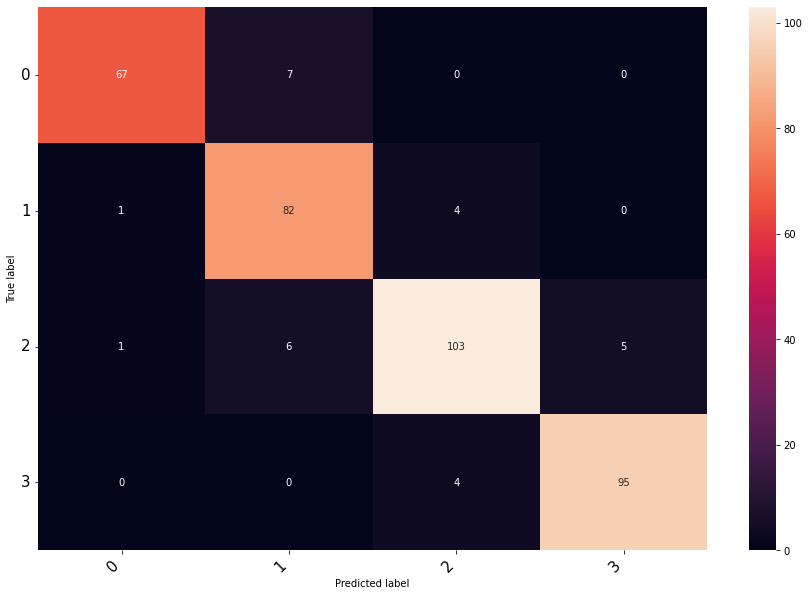

In [44]:
cm.visualize()

In [45]:
cm.class_accuracy

tensor([0.9054, 0.9425, 0.8957, 0.9596])

### GAT

In [46]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [47]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

 15%|█▌        | 88/576 [08:35<51:36,  6.35s/it]

#### Results

In [ ]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 30013/30013 [21:52<00:00, 22.87it/s]


In [ ]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [25],
 'out_features': 4,
 'num_heads': [4, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.1746439,
 'train_acc': 0.5733333230018616,
 'val_acc': 0.5493333339691162,
 'epoch': 84,
 'model_class': 'gat',
 'path_name': '0.5493333339691162_4_[25]_4_[4_2]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.43475906819404625,
 'val_mcc': 0.3998637615794784,
 'test_mcc': 0.4926227500907268,
 'train_rmse': 0.8809086218218096,
 'val_rmse': 0.9077444574328174,
 'test_rmse': 0.8500980335624043,
 'test_acc': 0.6159999966621399}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25],
 'out_features': 4,
 'num_heads': [4, 2],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.1746439,
 'train_acc': 0.5733333230018616,
 'val_acc': 0.5493333339691162,
 'epoch': 84,
 'model_class': 'gat',
 'path_name': '0.5493333339691162_4_[25]_4_[4_2]_bn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.43475906819404625,
 'val_mcc': 0.3998637615794784,
 'test_mcc': 0.4926227500907268,
 'train_rmse': 0.8809086218218096,
 'val_rmse': 0.9077444574328174,
 'test_rmse': 0.8500980335624043,
 'test_acc': 0.6159999966621399}

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15],
 'out_features': 4,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.1598674,
 'train_acc': 0.5653333067893982,
 'val_acc': 0.5973333120346069,
 'epoch': 99,
 'model_class': 'gat',
 'path_name': '0.5973333120346069_4_[15_15]_4_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.4231817410550492,
 'val_mcc': 0.46486381436446766,
 'test_mcc': 0.42152660702719874,
 'train_rmse': 0.9373722135132163,
 'val_rmse': 0.8793937305515279,
 'test_rmse': 0.862554346113913,
 'test_acc': 0.562666654586792}

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 30013/30013 [00:00<00:00, 31255.71it/s]
